#### Split our data

_My suggestion would be to use a split with these parameters for our validation_

In [ ]:
import pandas as pd
import pickle as pkl
with open('training_data.pkl', 'rb') as file:
    train_graphs = pkl.load(file)
with open('training_labels.pkl', 'rb') as file:
    train_labels = pkl.load(file)

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(train_graphs, train_labels, test_size=0.1, random_state=1)

#### Sklearn multiple classifiers

Import

In [ ]:
# # Code source: Gaël Varoquaux
# #              Andreas Müller
# # Modified for documentation by Jaques Grobler
# # License: BSD 3 clause

# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.datasets import make_moons, make_circles, make_classification
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.inspection import DecisionBoundaryDisplay


#### Original

Setup

In [ ]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

def myplot(ax, X_train, X_test, y_train, y_test, x_min, x_max, y_min, y_max, title):
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"  )
    # set axes
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

In [ ]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable_ds = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable_ds,
]

Classify and plot

In [ ]:
figure = plt.figure(figsize=(27, 9))

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess; split into training/test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42 )
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # plot dataset
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    title = "Input data" if ds_cnt == 0 else ""
    myplot(ax, X_train, X_test, y_train, y_test, x_min, x_max, y_min, y_max, title)
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        #Fit data
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        # pred = clf.predict_proba(X_test)
        # print(metrics.f1_score(y_test, clf.predict(X_test)))
        
        cm = plt.cm.RdBu
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        title = name if ds_cnt == 0 else ""
        myplot(ax, X_train, X_test, y_train, y_test, x_min, x_max, y_min, y_max, title)
        ax.text(x_max - 0.3, y_min + 0.3,  ("%.2f" % score).lstrip("0"),  size=15,  horizontalalignment="right",  )
        i += 1

plt.tight_layout()
plt.show()

#### Kaggle

Load data

In [2]:
import scipy.sparse as ss

In [9]:
with open('Data/training_labels.pkl', 'rb') as file:
    labels = pkl.load(file)
from lib import load_sparse_csr
WLData = load_sparse_csr('Data/WLKernel.npz')
WLData = ss.csr_matrix.toarray(WLData)
WLData.shape

(6000, 6000)

Single classifier: KNN, Cross-fold

In [ ]:
def crossfold(classif, X, y, n_splits, classif):
    n_splits = 10
    kf = KFold(n_splits=n_splits, random_state=1, shuffle=True)
    kf.get_n_splits(X)
    scores = np.empty(n_splits)
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        #Split
        X_train = X[train_index]
        y_train = y[train_index]
        #Fit
        clf = make_pipeline(StandardScaler(), classif)
        clf.fit(X_train, y_train)
        #Hit
        X_test = X[test_index]
        y_test = y[test_index]
        scores[i] = clf.score(X_test, y_test)
        pred = clf.predict(X_test)
        print(f"Fold {i}: {scores[i]}, {metrics.f1_score(y_test, pred)}")
        # print(f'{scores[i]*len(y_test)}/{len(y_test)}')
        # print(f'')
        #Count number of 1's 
        # pred[y_test==1]
    
    return scores, pred

In [10]:
# iterate over classifiers
X_train, X_validate, y_train, y_validate = train_test_split(WLData, labels, test_size=0.3, random_state=1)

    

In [26]:
# Creating a classifier instance
#
# rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=1, max_depth=50)
from sklearn import metrics
from sklearn.svm import SVC
rbf = SVC(gamma=2, C=1, probability=True, verbose=1)
rbf.fit(X_train, y_train)

In [27]:
rbf.fit(X_train, y_train)
pred = rbf.predict(X_validate)

In [ ]:
print(metrics.recall_score(y_validate, pred))
print(metrics.accuracy_score(y_validate, pred))
print(metrics.f1_score(y_validate, pred))

from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_validate, pred))

0.35365853658536583
0.93
0.4793388429752066


In [3]:
import pickle as pkl
import scipy.sparse as ss
from sklearn.model_selection import train_test_split
with open('Data/training_labels.pkl', 'rb') as file:
    labels = pkl.load(file)
from lib import load_sparse_csr
WLData = load_sparse_csr('Data/WLfeaturevectors.npz')
WLData = ss.csr_matrix.toarray(WLData)
print(WLData.shape)
X_train, X_validate, y_train, y_validate = train_test_split(WLData, labels, test_size=0.3, random_state=1)


In [15]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_valid_std = sc.transform(X_validate)
#

#


In [18]:
pca = PCA(n_components=len(X_train_std))
# Determine transformed features
X_train_pca = pca.fit_transform(X_train_std)



In [ ]:
np.savetxt('WLPCA_Xtrain_4200.txt', X_train_pca)
X_train_pca.shape

(4200, 4200)

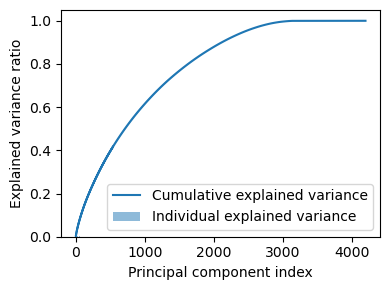

In [21]:
#
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_
# Cumulative sum of eigenvalues
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Create the visualization plot
import matplotlib.pyplot as plt
plt.figure(figsize=(4,3))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [26]:
np.where(cum_sum_eigenvalues>0.999)
X_train_pca_cut = X_train_pca[:, 0:3100]
X_train_pca_cut.shape

(4200, 3100)

In [29]:
X_validate_pca = pca.transform(X_validate)
X_validate_pca.shape

(1800, 4200)

In [30]:
from sklearn import metrics
from sklearn.svm import SVC
rbf = SVC(gamma=2, C=1, probability=True, verbose=1)
rbf.fit(X_train_pca_cut, y_train)

[LibSVM]

In [ ]:
X_validate_pca = pca.transform(X_validate)
pred = rbf.predict(X_validate_pca)
fpr, tpr, thresholds = metrics.roc_curve(y_validate, pred, pos_label=1)
print(f'AUC: {metrics.auc(fpr, tpr)}')